In [1]:
from dataset import LFWDataset # .py to load LFW dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import transforms
import torchprofile
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

In [2]:
seed = 25

batch_size = 8
n_epochs = 150
learning_rate = 0.001

In [3]:
data = LFWDataset(
    faces_folder="../data/faces",
    smiling_labels_file="../data/SMILE_list.txt",
    non_smiling_labels_file="../data/NON-SMILE_list.txt",
    transform=transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5),       # mean
                            (0.5, 0.5, 0.5))        # std
    ])
)

In [4]:
# separate non-smiling faces and smiling faces
non_smiling_faces = [data[i] for i in range(len(data)) if data.labels[i] == 0]
len(non_smiling_faces)

603

In [5]:
smiling_faces = [data[i] for i in range(len(data)) if data.labels[i] == 1]
len(smiling_faces)

600

In [6]:
# split dataset into train and validation sets
train_size = int(0.8 * len(non_smiling_faces))
train_dataset_0, test_dataset_0 = torch.utils.data.random_split(non_smiling_faces, [train_size, len(non_smiling_faces) - train_size], generator=torch.Generator().manual_seed(seed))

train_smiling, test_smiling = torch.utils.data.random_split(smiling_faces, [train_size, len(smiling_faces) - train_size], generator=torch.Generator().manual_seed(seed))


In [7]:
X_test = torch.stack([non_smiling_faces[i][0] for i in test_dataset_0.indices])
X_train = torch.stack([non_smiling_faces[i][0] for i in train_dataset_0.indices])

X_test_smiling = torch.stack([smiling_faces[i][0] for i in test_smiling.indices])
X_train_smiling = torch.stack([smiling_faces[i][0] for i in train_smiling.indices])

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train = X_train.to(device)
X_test = X_test.to(device)

X_test_smiling = X_test_smiling.to(device)
X_train_smiling = X_train_smiling.to(device)

In [9]:
train_dataset = TensorDataset(X_train, X_train)
smiling_train_dataset = TensorDataset(X_train_smiling, X_train_smiling)


val_size = int(0.15 * len(data))
train_data, val_data = torch.utils.data.random_split(train_dataset, [len(train_dataset) - val_size, val_size], generator=torch.Generator().manual_seed(seed))
smiling_tr_data, smiling_val_data = torch.utils.data.random_split(smiling_train_dataset, [len(smiling_train_dataset) - val_size, val_size], generator=torch.Generator().manual_seed(seed))

In [10]:
X_val = torch.stack([non_smiling_faces[i][0] for i in val_data.indices]).to(device)

X_val_smiling = torch.stack([smiling_faces[i][0] for i in smiling_val_data.indices]).to(device)


In [11]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, X_test), batch_size=batch_size, shuffle=False)

In [12]:
def count_parameters(model):
    """Return total parameters."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad) # only trainable params

In [13]:
def train_autoencoder(autoencoder, train_loader, val_loader, epochs=100, lr=0.01):
    """Train the autoencoder model."""
    # Move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    autoencoder = autoencoder.to(device)
    
    # Define optimizer and loss function
    optimizer = optim.Adam(autoencoder.parameters(), lr=lr)
    criterion = nn.L1Loss()
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #optimizer, factor=0.5, patience=5
#) # decaying lr
    
    # Training loop
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(epochs), desc="Training Progress"):
        # Training
        autoencoder.train()
        train_loss = 0
        for batch_data, batch_targets in train_loader:
            batch_data = batch_data.to(device)
            batch_targets = batch_targets.to(device)
            optimizer.zero_grad()
            outputs = autoencoder(batch_data)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        autoencoder.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_data, batch_targets in val_loader:
                batch_data = batch_data.to(device)
                batch_targets = batch_targets.to(device)
                outputs = autoencoder(batch_data)
                loss = criterion(outputs, batch_targets)
                val_loss += loss.item()
        
        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(val_loader)
        train_losses.append(train_loss_avg)
        val_losses.append(val_loss_avg)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss_avg:.4f}, Val Loss: {val_loss_avg:.4f}")

        #scheduler.step(val_loss_avg)
    
    return train_losses, val_losses

In [14]:
def visualize_results(autoencoder, x_test, n=10):
    """Visualize original and reconstructed images."""
    # Encode and decode images from the test set.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    autoencoder.eval()
    with torch.no_grad():
        decoded_imgs = autoencoder(x_test.to(device))

    # Convert to numpy for plotting (move to CPU first)
    x_test_np = (x_test.cpu().numpy() + 1) / 2
    decoded_imgs_np = (decoded_imgs.cpu().numpy() + 1) / 2

    # Plot the results
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test_np[i].transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs_np[i].transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [15]:
def anomaly_accuracy(model, x_norm, x_anom, threshold=None):
    """
    Anomaly-detection accuracy using reconstruction error.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        # Compute reconstruction errors
        r_norm = torch.mean(torch.abs(model(x_norm.to(device)) - x_norm.to(device)), dim=(1,2,3))
        r_anom = torch.mean(torch.abs(model(x_anom.to(device)) - x_anom.to(device)), dim=(1,2,3))

    # labels: 0 = normal, 1 = anomaly
    labels = torch.cat([torch.zeros_like(r_norm), torch.ones_like(r_anom)])
    scores = torch.cat([r_norm, r_anom])

    # best accuracy threshold
    if threshold == None:
        thresholds = torch.linspace(scores.min(), scores.max(), 200)
        best_acc, best_th = 0, None
        for th in thresholds:
            preds = (scores > th).int()
            acc = (preds == labels).float().mean()
            if acc > best_acc:
                best_acc = acc
                best_th = th
        return best_acc.item(), best_th.item()
    
    preds = (scores > threshold).int()
    acc = (preds == labels).float().mean()
    return acc.item(), threshold


In [16]:
def get_flops(model, input_size):
    """
    # of flops
    """
    model = model.cpu()  # torchprofile only traces CPU ops, but counts FLOPs correctly
    x = torch.randn(*input_size)
    flops = torchprofile.profile_macs(model, x) * 2  # MACs × 2 = FLOPs
    return flops

In [17]:
# Define the convolutional autoencoder model
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # 64*64*3 --> 64*64*16
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # --> 32*32*32
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # --> 16*16*64
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # --> 8*8*128
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # --> 4*4*256
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False), # 4*4*256 --> 8*8*256
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1), # --> 8*8*128
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False), # --> 16*16*128
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1), # --> 16*16*64
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False), # --> 32*32*64
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1), # --> 32*32*32
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False), # --> 64*64*32
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1), # --> 64*64*16
            nn.ReLU(),

            nn.Conv2d(16, 3, kernel_size=1, stride=1, padding=0), # --> 64*64*3
        )
        
        self.tanh = nn.Tanh()
    
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        output = self.tanh(decoded)
        return output


In [18]:
autoencoder = ConvAutoencoder()

start = time.perf_counter()

train_losses, val_losses = train_autoencoder(
    autoencoder, train_loader, val_loader,
    epochs=n_epochs, lr=learning_rate
)

# Ensure GPU ops complete before stopping timer
if torch.cuda.is_available():
    torch.cuda.synchronize()
end = time.perf_counter()

training_time = end - start

Training Progress:   1%|          | 1/150 [00:01<04:07,  1.66s/it]

Epoch 1/150, Train Loss: 0.1918, Val Loss: 0.1711


Training Progress:   1%|▏         | 2/150 [00:01<02:04,  1.19it/s]

Epoch 2/150, Train Loss: 0.1632, Val Loss: 0.1531


Training Progress:   2%|▏         | 3/150 [00:02<01:21,  1.80it/s]

Epoch 3/150, Train Loss: 0.1510, Val Loss: 0.1461


Training Progress:   3%|▎         | 5/150 [00:02<00:49,  2.91it/s]

Epoch 4/150, Train Loss: 0.1512, Val Loss: 0.1405
Epoch 5/150, Train Loss: 0.1432, Val Loss: 0.1440


Training Progress:   5%|▍         | 7/150 [00:02<00:37,  3.83it/s]

Epoch 6/150, Train Loss: 0.1430, Val Loss: 0.1335
Epoch 7/150, Train Loss: 0.1353, Val Loss: 0.1310


Training Progress:   6%|▌         | 9/150 [00:03<00:32,  4.40it/s]

Epoch 8/150, Train Loss: 0.1400, Val Loss: 0.1321
Epoch 9/150, Train Loss: 0.1394, Val Loss: 0.1282


Training Progress:   7%|▋         | 11/150 [00:03<00:29,  4.75it/s]

Epoch 10/150, Train Loss: 0.1300, Val Loss: 0.1236
Epoch 11/150, Train Loss: 0.1345, Val Loss: 0.1292


Training Progress:   9%|▊         | 13/150 [00:04<00:26,  5.14it/s]

Epoch 12/150, Train Loss: 0.1365, Val Loss: 0.1351
Epoch 13/150, Train Loss: 0.1313, Val Loss: 0.1263


Training Progress:  10%|█         | 15/150 [00:04<00:26,  5.15it/s]

Epoch 14/150, Train Loss: 0.1274, Val Loss: 0.1335
Epoch 15/150, Train Loss: 0.1281, Val Loss: 0.1206


Training Progress:  11%|█▏        | 17/150 [00:04<00:24,  5.41it/s]

Epoch 16/150, Train Loss: 0.1287, Val Loss: 0.1232
Epoch 17/150, Train Loss: 0.1236, Val Loss: 0.1215


Training Progress:  13%|█▎        | 19/150 [00:05<00:23,  5.50it/s]

Epoch 18/150, Train Loss: 0.1278, Val Loss: 0.1156
Epoch 19/150, Train Loss: 0.1178, Val Loss: 0.1292


Training Progress:  14%|█▍        | 21/150 [00:05<00:24,  5.34it/s]

Epoch 20/150, Train Loss: 0.1266, Val Loss: 0.1179
Epoch 21/150, Train Loss: 0.1314, Val Loss: 0.1189


Training Progress:  15%|█▌        | 23/150 [00:05<00:23,  5.43it/s]

Epoch 22/150, Train Loss: 0.1233, Val Loss: 0.1112
Epoch 23/150, Train Loss: 0.1204, Val Loss: 0.1126


Training Progress:  17%|█▋        | 25/150 [00:06<00:23,  5.43it/s]

Epoch 24/150, Train Loss: 0.1187, Val Loss: 0.1115
Epoch 25/150, Train Loss: 0.1158, Val Loss: 0.1149


Training Progress:  18%|█▊        | 27/150 [00:06<00:23,  5.34it/s]

Epoch 26/150, Train Loss: 0.1174, Val Loss: 0.1222
Epoch 27/150, Train Loss: 0.1131, Val Loss: 0.1114


Training Progress:  19%|█▉        | 29/150 [00:07<00:22,  5.43it/s]

Epoch 28/150, Train Loss: 0.1168, Val Loss: 0.1118
Epoch 29/150, Train Loss: 0.1152, Val Loss: 0.1087


Training Progress:  20%|██        | 30/150 [00:07<00:22,  5.45it/s]

Epoch 30/150, Train Loss: 0.1128, Val Loss: 0.1158


Training Progress:  21%|██▏       | 32/150 [00:07<00:21,  5.45it/s]

Epoch 31/150, Train Loss: 0.1215, Val Loss: 0.1196
Epoch 32/150, Train Loss: 0.1139, Val Loss: 0.1097


Training Progress:  23%|██▎       | 34/150 [00:08<00:22,  5.24it/s]

Epoch 33/150, Train Loss: 0.1109, Val Loss: 0.1082
Epoch 34/150, Train Loss: 0.1130, Val Loss: 0.1117


Training Progress:  24%|██▍       | 36/150 [00:08<00:21,  5.29it/s]

Epoch 35/150, Train Loss: 0.1109, Val Loss: 0.1116
Epoch 36/150, Train Loss: 0.1155, Val Loss: 0.1088


Training Progress:  25%|██▌       | 38/150 [00:08<00:20,  5.37it/s]

Epoch 37/150, Train Loss: 0.1090, Val Loss: 0.1057
Epoch 38/150, Train Loss: 0.1088, Val Loss: 0.1040


Training Progress:  27%|██▋       | 40/150 [00:09<00:20,  5.42it/s]

Epoch 39/150, Train Loss: 0.1024, Val Loss: 0.1022
Epoch 40/150, Train Loss: 0.1052, Val Loss: 0.1041


Training Progress:  28%|██▊       | 42/150 [00:09<00:19,  5.41it/s]

Epoch 41/150, Train Loss: 0.1029, Val Loss: 0.1055
Epoch 42/150, Train Loss: 0.1063, Val Loss: 0.1037


Training Progress:  29%|██▉       | 44/150 [00:09<00:19,  5.41it/s]

Epoch 43/150, Train Loss: 0.1031, Val Loss: 0.1025
Epoch 44/150, Train Loss: 0.1020, Val Loss: 0.1049


Training Progress:  31%|███       | 46/150 [00:10<00:19,  5.42it/s]

Epoch 45/150, Train Loss: 0.1010, Val Loss: 0.1045
Epoch 46/150, Train Loss: 0.1016, Val Loss: 0.1076


Training Progress:  32%|███▏      | 48/150 [00:10<00:18,  5.38it/s]

Epoch 47/150, Train Loss: 0.1090, Val Loss: 0.1062
Epoch 48/150, Train Loss: 0.0986, Val Loss: 0.1006


Training Progress:  33%|███▎      | 49/150 [00:10<00:19,  5.21it/s]

Epoch 49/150, Train Loss: 0.0997, Val Loss: 0.1034


Training Progress:  34%|███▍      | 51/150 [00:11<00:19,  5.04it/s]

Epoch 50/150, Train Loss: 0.1017, Val Loss: 0.1020
Epoch 51/150, Train Loss: 0.1020, Val Loss: 0.1084


Training Progress:  35%|███▌      | 53/150 [00:11<00:19,  4.91it/s]

Epoch 52/150, Train Loss: 0.0992, Val Loss: 0.1016
Epoch 53/150, Train Loss: 0.0951, Val Loss: 0.1008


Training Progress:  37%|███▋      | 55/150 [00:12<00:18,  5.11it/s]

Epoch 54/150, Train Loss: 0.0982, Val Loss: 0.1052
Epoch 55/150, Train Loss: 0.0986, Val Loss: 0.1022


Training Progress:  38%|███▊      | 57/150 [00:12<00:19,  4.89it/s]

Epoch 56/150, Train Loss: 0.0939, Val Loss: 0.1058
Epoch 57/150, Train Loss: 0.0982, Val Loss: 0.1064


Training Progress:  39%|███▉      | 59/150 [00:12<00:18,  4.91it/s]

Epoch 58/150, Train Loss: 0.0952, Val Loss: 0.1047
Epoch 59/150, Train Loss: 0.0921, Val Loss: 0.1023


Training Progress:  40%|████      | 60/150 [00:13<00:18,  4.94it/s]

Epoch 60/150, Train Loss: 0.0906, Val Loss: 0.1132


Training Progress:  41%|████      | 61/150 [00:13<00:18,  4.87it/s]

Epoch 61/150, Train Loss: 0.0911, Val Loss: 0.0989


Training Progress:  41%|████▏     | 62/150 [00:13<00:18,  4.82it/s]

Epoch 62/150, Train Loss: 0.0910, Val Loss: 0.1004


Training Progress:  42%|████▏     | 63/150 [00:13<00:18,  4.73it/s]

Epoch 63/150, Train Loss: 0.0933, Val Loss: 0.1063


Training Progress:  43%|████▎     | 64/150 [00:13<00:18,  4.67it/s]

Epoch 64/150, Train Loss: 0.0921, Val Loss: 0.1021


Training Progress:  43%|████▎     | 65/150 [00:14<00:18,  4.71it/s]

Epoch 65/150, Train Loss: 0.0877, Val Loss: 0.0982


Training Progress:  44%|████▍     | 66/150 [00:14<00:17,  4.68it/s]

Epoch 66/150, Train Loss: 0.0883, Val Loss: 0.1037


Training Progress:  45%|████▍     | 67/150 [00:14<00:17,  4.64it/s]

Epoch 67/150, Train Loss: 0.0876, Val Loss: 0.1024


Training Progress:  46%|████▌     | 69/150 [00:14<00:16,  4.79it/s]

Epoch 68/150, Train Loss: 0.0898, Val Loss: 0.1006
Epoch 69/150, Train Loss: 0.0930, Val Loss: 0.1070


Training Progress:  47%|████▋     | 71/150 [00:15<00:16,  4.92it/s]

Epoch 70/150, Train Loss: 0.0904, Val Loss: 0.1014
Epoch 71/150, Train Loss: 0.0878, Val Loss: 0.0968


Training Progress:  49%|████▊     | 73/150 [00:15<00:14,  5.16it/s]

Epoch 72/150, Train Loss: 0.0849, Val Loss: 0.0997
Epoch 73/150, Train Loss: 0.0860, Val Loss: 0.0982


Training Progress:  50%|█████     | 75/150 [00:16<00:14,  5.26it/s]

Epoch 74/150, Train Loss: 0.0874, Val Loss: 0.1022
Epoch 75/150, Train Loss: 0.0845, Val Loss: 0.0992


Training Progress:  51%|█████▏    | 77/150 [00:16<00:14,  5.19it/s]

Epoch 76/150, Train Loss: 0.0862, Val Loss: 0.0977
Epoch 77/150, Train Loss: 0.0841, Val Loss: 0.0963


Training Progress:  52%|█████▏    | 78/150 [00:16<00:13,  5.19it/s]

Epoch 78/150, Train Loss: 0.0828, Val Loss: 0.0979


Training Progress:  53%|█████▎    | 79/150 [00:16<00:14,  5.03it/s]

Epoch 79/150, Train Loss: 0.0849, Val Loss: 0.0980


Training Progress:  53%|█████▎    | 80/150 [00:17<00:14,  4.91it/s]

Epoch 80/150, Train Loss: 0.0835, Val Loss: 0.0964


Training Progress:  54%|█████▍    | 81/150 [00:17<00:14,  4.85it/s]

Epoch 81/150, Train Loss: 0.0815, Val Loss: 0.1059


Training Progress:  55%|█████▍    | 82/150 [00:17<00:14,  4.83it/s]

Epoch 82/150, Train Loss: 0.0820, Val Loss: 0.1011


Training Progress:  55%|█████▌    | 83/150 [00:17<00:14,  4.77it/s]

Epoch 83/150, Train Loss: 0.0819, Val Loss: 0.0968


Training Progress:  57%|█████▋    | 85/150 [00:18<00:13,  4.77it/s]

Epoch 84/150, Train Loss: 0.0816, Val Loss: 0.0961
Epoch 85/150, Train Loss: 0.0834, Val Loss: 0.0988


Training Progress:  57%|█████▋    | 86/150 [00:18<00:13,  4.79it/s]

Epoch 86/150, Train Loss: 0.0823, Val Loss: 0.0950


Training Progress:  58%|█████▊    | 87/150 [00:18<00:13,  4.76it/s]

Epoch 87/150, Train Loss: 0.0822, Val Loss: 0.1028


Training Progress:  59%|█████▊    | 88/150 [00:18<00:13,  4.69it/s]

Epoch 88/150, Train Loss: 0.0807, Val Loss: 0.0949


Training Progress:  59%|█████▉    | 89/150 [00:19<00:13,  4.67it/s]

Epoch 89/150, Train Loss: 0.0852, Val Loss: 0.0995


Training Progress:  60%|██████    | 90/150 [00:19<00:12,  4.62it/s]

Epoch 90/150, Train Loss: 0.0795, Val Loss: 0.0951


Training Progress:  61%|██████    | 91/150 [00:19<00:12,  4.62it/s]

Epoch 91/150, Train Loss: 0.0815, Val Loss: 0.0971


Training Progress:  61%|██████▏   | 92/150 [00:19<00:12,  4.66it/s]

Epoch 92/150, Train Loss: 0.0799, Val Loss: 0.0975


Training Progress:  62%|██████▏   | 93/150 [00:19<00:12,  4.60it/s]

Epoch 93/150, Train Loss: 0.0787, Val Loss: 0.0992


Training Progress:  63%|██████▎   | 94/150 [00:20<00:12,  4.58it/s]

Epoch 94/150, Train Loss: 0.0795, Val Loss: 0.0988


Training Progress:  63%|██████▎   | 95/150 [00:20<00:12,  4.57it/s]

Epoch 95/150, Train Loss: 0.0799, Val Loss: 0.0976


Training Progress:  64%|██████▍   | 96/150 [00:20<00:11,  4.57it/s]

Epoch 96/150, Train Loss: 0.0788, Val Loss: 0.0957


Training Progress:  65%|██████▍   | 97/150 [00:20<00:11,  4.52it/s]

Epoch 97/150, Train Loss: 0.0789, Val Loss: 0.0979


Training Progress:  65%|██████▌   | 98/150 [00:21<00:11,  4.49it/s]

Epoch 98/150, Train Loss: 0.0777, Val Loss: 0.0985


Training Progress:  66%|██████▌   | 99/150 [00:21<00:11,  4.47it/s]

Epoch 99/150, Train Loss: 0.0779, Val Loss: 0.0950


Training Progress:  67%|██████▋   | 100/150 [00:21<00:11,  4.48it/s]

Epoch 100/150, Train Loss: 0.0776, Val Loss: 0.0964


Training Progress:  68%|██████▊   | 102/150 [00:21<00:10,  4.60it/s]

Epoch 101/150, Train Loss: 0.0775, Val Loss: 0.0950
Epoch 102/150, Train Loss: 0.0788, Val Loss: 0.0957


Training Progress:  69%|██████▊   | 103/150 [00:22<00:10,  4.56it/s]

Epoch 103/150, Train Loss: 0.0787, Val Loss: 0.0977


Training Progress:  69%|██████▉   | 104/150 [00:22<00:10,  4.60it/s]

Epoch 104/150, Train Loss: 0.0764, Val Loss: 0.0957


Training Progress:  70%|███████   | 105/150 [00:22<00:09,  4.57it/s]

Epoch 105/150, Train Loss: 0.0753, Val Loss: 0.0936


Training Progress:  71%|███████   | 106/150 [00:22<00:09,  4.61it/s]

Epoch 106/150, Train Loss: 0.0768, Val Loss: 0.0961


Training Progress:  72%|███████▏  | 108/150 [00:23<00:09,  4.64it/s]

Epoch 107/150, Train Loss: 0.0764, Val Loss: 0.0954
Epoch 108/150, Train Loss: 0.0779, Val Loss: 0.0979


Training Progress:  73%|███████▎  | 109/150 [00:23<00:08,  4.85it/s]

Epoch 109/150, Train Loss: 0.0781, Val Loss: 0.0957


Training Progress:  74%|███████▍  | 111/150 [00:23<00:08,  4.70it/s]

Epoch 110/150, Train Loss: 0.0778, Val Loss: 0.0956
Epoch 111/150, Train Loss: 0.0751, Val Loss: 0.0948


Training Progress:  75%|███████▌  | 113/150 [00:24<00:07,  4.78it/s]

Epoch 112/150, Train Loss: 0.0745, Val Loss: 0.1018
Epoch 113/150, Train Loss: 0.0777, Val Loss: 0.0948


Training Progress:  76%|███████▌  | 114/150 [00:24<00:07,  4.73it/s]

Epoch 114/150, Train Loss: 0.0752, Val Loss: 0.0954


Training Progress:  77%|███████▋  | 115/150 [00:24<00:07,  4.71it/s]

Epoch 115/150, Train Loss: 0.0748, Val Loss: 0.0961


Training Progress:  77%|███████▋  | 116/150 [00:24<00:07,  4.68it/s]

Epoch 116/150, Train Loss: 0.0755, Val Loss: 0.0958


Training Progress:  78%|███████▊  | 117/150 [00:25<00:07,  4.66it/s]

Epoch 117/150, Train Loss: 0.0741, Val Loss: 0.0942


Training Progress:  79%|███████▊  | 118/150 [00:25<00:06,  4.62it/s]

Epoch 118/150, Train Loss: 0.0724, Val Loss: 0.0941


Training Progress:  79%|███████▉  | 119/150 [00:25<00:06,  4.59it/s]

Epoch 119/150, Train Loss: 0.0734, Val Loss: 0.0959


Training Progress:  80%|████████  | 120/150 [00:25<00:06,  4.60it/s]

Epoch 120/150, Train Loss: 0.0740, Val Loss: 0.0962


Training Progress:  81%|████████  | 121/150 [00:25<00:06,  4.65it/s]

Epoch 121/150, Train Loss: 0.0734, Val Loss: 0.0937


Training Progress:  81%|████████▏ | 122/150 [00:26<00:05,  4.71it/s]

Epoch 122/150, Train Loss: 0.0720, Val Loss: 0.0968


Training Progress:  82%|████████▏ | 123/150 [00:26<00:05,  4.65it/s]

Epoch 123/150, Train Loss: 0.0725, Val Loss: 0.1004


Training Progress:  83%|████████▎ | 124/150 [00:26<00:05,  4.64it/s]

Epoch 124/150, Train Loss: 0.0730, Val Loss: 0.0952


Training Progress:  83%|████████▎ | 125/150 [00:26<00:05,  4.54it/s]

Epoch 125/150, Train Loss: 0.0723, Val Loss: 0.0969


Training Progress:  84%|████████▍ | 126/150 [00:27<00:05,  4.53it/s]

Epoch 126/150, Train Loss: 0.0726, Val Loss: 0.1009


Training Progress:  85%|████████▍ | 127/150 [00:27<00:05,  4.59it/s]

Epoch 127/150, Train Loss: 0.0746, Val Loss: 0.1006


Training Progress:  85%|████████▌ | 128/150 [00:27<00:04,  4.62it/s]

Epoch 128/150, Train Loss: 0.0708, Val Loss: 0.0963


Training Progress:  86%|████████▌ | 129/150 [00:27<00:04,  4.60it/s]

Epoch 129/150, Train Loss: 0.0725, Val Loss: 0.0949


Training Progress:  87%|████████▋ | 130/150 [00:27<00:04,  4.63it/s]

Epoch 130/150, Train Loss: 0.0721, Val Loss: 0.0959


Training Progress:  87%|████████▋ | 131/150 [00:28<00:04,  4.63it/s]

Epoch 131/150, Train Loss: 0.0740, Val Loss: 0.0943


Training Progress:  88%|████████▊ | 132/150 [00:28<00:03,  4.65it/s]

Epoch 132/150, Train Loss: 0.0715, Val Loss: 0.0965


Training Progress:  89%|████████▊ | 133/150 [00:28<00:03,  4.62it/s]

Epoch 133/150, Train Loss: 0.0721, Val Loss: 0.0963


Training Progress:  89%|████████▉ | 134/150 [00:28<00:03,  4.58it/s]

Epoch 134/150, Train Loss: 0.0713, Val Loss: 0.0958


Training Progress:  90%|█████████ | 135/150 [00:29<00:03,  4.58it/s]

Epoch 135/150, Train Loss: 0.0733, Val Loss: 0.0965


Training Progress:  91%|█████████ | 136/150 [00:29<00:03,  4.54it/s]

Epoch 136/150, Train Loss: 0.0739, Val Loss: 0.0967


Training Progress:  91%|█████████▏| 137/150 [00:29<00:02,  4.51it/s]

Epoch 137/150, Train Loss: 0.0707, Val Loss: 0.0942


Training Progress:  92%|█████████▏| 138/150 [00:29<00:02,  4.41it/s]

Epoch 138/150, Train Loss: 0.0714, Val Loss: 0.0974


Training Progress:  93%|█████████▎| 139/150 [00:29<00:02,  4.42it/s]

Epoch 139/150, Train Loss: 0.0700, Val Loss: 0.0953


Training Progress:  93%|█████████▎| 140/150 [00:30<00:02,  4.36it/s]

Epoch 140/150, Train Loss: 0.0696, Val Loss: 0.0949


Training Progress:  94%|█████████▍| 141/150 [00:30<00:02,  4.43it/s]

Epoch 141/150, Train Loss: 0.0694, Val Loss: 0.0954


Training Progress:  95%|█████████▍| 142/150 [00:30<00:01,  4.46it/s]

Epoch 142/150, Train Loss: 0.0707, Val Loss: 0.0982


Training Progress:  95%|█████████▌| 143/150 [00:30<00:01,  4.50it/s]

Epoch 143/150, Train Loss: 0.0717, Val Loss: 0.0971


Training Progress:  97%|█████████▋| 145/150 [00:31<00:01,  4.76it/s]

Epoch 144/150, Train Loss: 0.0688, Val Loss: 0.1003
Epoch 145/150, Train Loss: 0.0706, Val Loss: 0.0958


Training Progress:  97%|█████████▋| 146/150 [00:31<00:00,  4.60it/s]

Epoch 146/150, Train Loss: 0.0687, Val Loss: 0.0929


Training Progress:  98%|█████████▊| 147/150 [00:31<00:00,  4.61it/s]

Epoch 147/150, Train Loss: 0.0686, Val Loss: 0.0947


Training Progress:  99%|█████████▊| 148/150 [00:31<00:00,  4.52it/s]

Epoch 148/150, Train Loss: 0.0686, Val Loss: 0.0982


Training Progress: 100%|██████████| 150/150 [00:32<00:00,  4.62it/s]

Epoch 149/150, Train Loss: 0.0709, Val Loss: 0.0966
Epoch 150/150, Train Loss: 0.0691, Val Loss: 0.0951


Training Progress: 100%|██████████| 150/150 [00:32<00:00,  4.64it/s]


In [19]:
autoencoder = autoencoder.to(device)
autoencoder.eval()

sample_input = next(iter(test_loader))[0][:1]

times = []

with torch.no_grad():
    for i in range(100):
        # Prepare input
        x = sample_input.to(device)

        # Start timer
        if device == "cuda":
            torch.cuda.synchronize()
        t0 = time.perf_counter()

        # Forward pass
        _ = autoencoder(x)

        # Finish
        if device == "cuda":
            torch.cuda.synchronize()
        t1 = time.perf_counter()

        times.append((t1 - t0) * 1000)  # ms

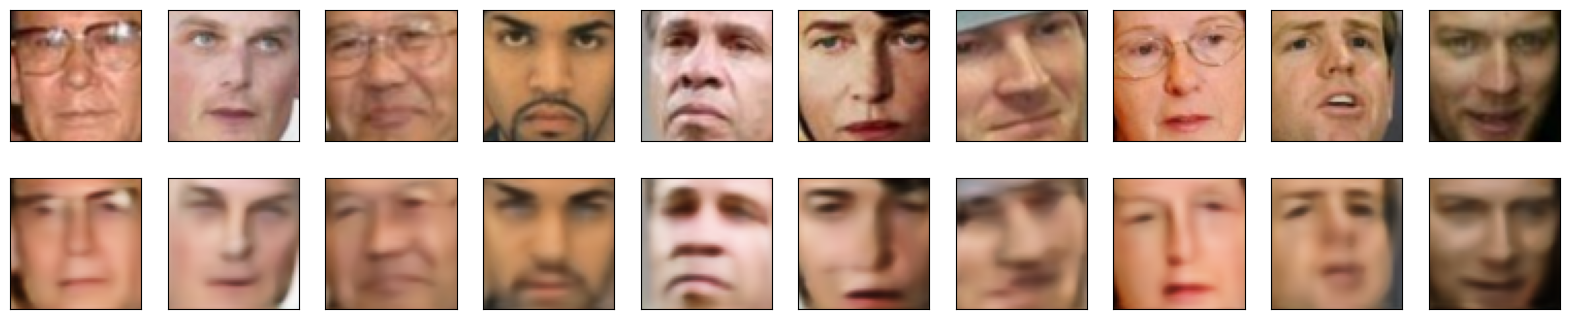

In [20]:
visualize_results(autoencoder, X_val)

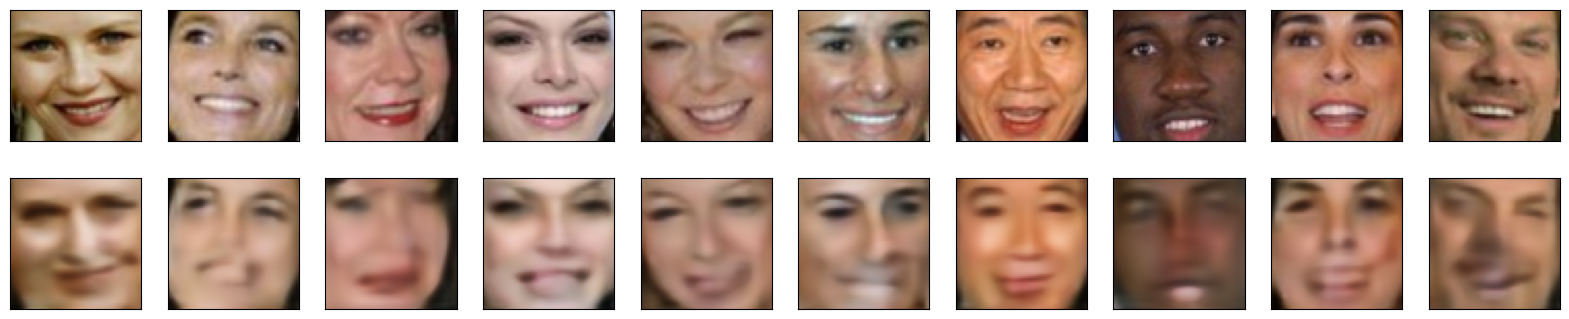

In [21]:
visualize_results(autoencoder, X_test_smiling)

In [22]:
training_time # seconds

32.34528170002159

In [23]:
np.mean(times), np.std(times) # miliseconds

(np.float64(1.2060459941858426), np.float64(1.0411296314493297))

In [24]:
# accuracy
acc, best_th = anomaly_accuracy(autoencoder, X_val, X_val_smiling)
acc, best_th

(0.7583333253860474, 0.08717183768749237)

In [25]:
acc_test, _ = anomaly_accuracy(autoencoder, X_test, X_test_smiling, threshold=best_th)
acc_test

0.6276150345802307

In [28]:
count_parameters(autoencoder)

785955

In [27]:
flops = get_flops(autoencoder, (1,3,64,64))
flops

194945024